In [1]:
# ===== 사용자 설정 =====
HF_REPO_IMAGES = "pomupomu2/test_hbr_images"
HF_REPO_META   = "pomupomu2/test_hbr_meta"
HF_PRIVATE = True

QUERY_TAGS = "heaven_burns_red"  # ✅ 이번 테스트 캐릭터 태그

SLEEP_SEC = 0.8
RETRIES = 10
ABORT_SKIPS = 200
UPDATED_RESCAN_PAGES = 3     # order:updated 상위 N페이지 재스캔 (페이지당 100)
WORK_DIR = "/content/dl_work"

print("Config loaded.")
print("images repo:", HF_REPO_IMAGES)
print("meta repo  :", HF_REPO_META)
print("tag        :", QUERY_TAGS)

Config loaded.
images repo: pomupomu2/test_hbr_images
meta repo  : pomupomu2/test_hbr_meta
tag        : heaven_burns_red


In [2]:
!pip -q install -U "requests==2.32.4" "huggingface-hub==0.34.4" "datasets>=2.20.0" "gallery-dl>=1.28.0"

code = r'''
import os, json, glob, shutil, subprocess, time
from dataclasses import dataclass
from typing import Dict, Any, List, Optional, Set, Tuple

import requests
from huggingface_hub import HfApi, create_repo, hf_hub_download
from datasets import Dataset, Features, Value, Sequence, Image as HFImage, concatenate_datasets

IMAGE_EXTS = {".jpg", ".jpeg", ".png", ".webp", ".gif"}
DANBOORU = "https://danbooru.donmai.us"


def _safe_mkdir(p: str) -> None:
    os.makedirs(p, exist_ok=True)

def _now_iso() -> str:
    return time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime())

def _split_tags(s: str) -> List[str]:
    return [t for t in (s or "").split() if t]


def image_features() -> Features:
    return Features({
        "md5": Value("string"),
        "image": HFImage(),
        "file_ext": Value("string"),
        "file_size": Value("int64"),
        "first_seen_post_id": Value("int64"),
        "first_seen_at": Value("string"),
        "source_file_url": Value("string"),
    })

def meta_features() -> Features:
    return Features({
        "post_id": Value("int64"),
        "updated_at": Value("string"),
        "created_at": Value("string"),
        "md5": Value("string"),
        "rating": Value("string"),
        "score": Value("int64"),
        "fav_count": Value("int64"),
        "parent_id": Value("int64"),
        "source": Value("string"),
        "is_deleted": Value("bool"),
        "tag_artist": Sequence(Value("string")),
        "tag_copyright": Sequence(Value("string")),
        "tag_character": Sequence(Value("string")),
        "tag_general": Sequence(Value("string")),
        "tag_meta": Sequence(Value("string")),   # ✅ Danbooru "Meta" 섹션 태그
        "post_url": Value("string"),
        "file_url": Value("string"),
        "large_file_url": Value("string"),
        "preview_file_url": Value("string"),
    })


@dataclass
class Config:
    hf_repo_images: str
    hf_repo_meta: str
    hf_private: bool
    query_tags: str
    sleep_sec: float
    retries: int
    abort_skips: int
    updated_rescan_pages: int
    work_dir: str
    main_range_pages: int


class HFStore:
    def __init__(self, repo_images: str, token: str):
        self.repo_images = repo_images
        self.token = token
        self.api = HfApi(token=token)

    def ensure_repo(self, private: bool) -> None:
        create_repo(self.repo_images, repo_type="dataset", private=private, exist_ok=True, token=self.token)

    def load_state(self) -> Dict[str, Any]:
        try:
            p = hf_hub_download(self.repo_images, repo_type="dataset", filename="state/state.json", token=self.token)
            with open(p, "r", encoding="utf-8") as f:
                return json.load(f)
        except Exception:
            return {"last_run_at": None}

    def save_state(self, state: Dict[str, Any]) -> None:
        tmp = "/tmp/state.json"
        _safe_mkdir("/tmp")
        with open(tmp, "w", encoding="utf-8") as f:
            json.dump(state, f, ensure_ascii=False, indent=2)
        self.api.upload_file(
            path_or_fileobj=tmp,
            path_in_repo="state/state.json",
            repo_id=self.repo_images,
            repo_type="dataset",
            token=self.token,
        )

    def load_archive_to(self, local_archive_path: str) -> bool:
        for attempt in range(2):
            try:
                p = hf_hub_download(self.repo_images, repo_type="dataset", filename="state/archive.sqlite3", token=self.token)
                shutil.copy(p, local_archive_path)
                return True
            except Exception as e:
                print(f"[WARN] failed to download archive from HF (attempt={attempt+1}/2): {e}")
                time.sleep(1.0)
        return False

    def save_archive(self, local_archive_path: str) -> None:
        self.api.upload_file(
            path_or_fileobj=local_archive_path,
            path_in_repo="state/archive.sqlite3",
            repo_id=self.repo_images,
            repo_type="dataset",
            token=self.token,
        )


def _load_split(repo_id: str, split: str, token: str) -> Optional[Dataset]:
    try:
        from datasets import load_dataset
        return load_dataset(repo_id, split=split, token=token)
    except Exception as e:
        print(f"[WARN] load_dataset failed for {repo_id} split={split}: {e}")
        return None


def _dedup_images(ds: Dataset) -> Dataset:
    if len(ds) == 0:
        return ds
    if "first_seen_at" in ds.column_names:
        ds = ds.sort("first_seen_at")

    seen = set()
    keep = []
    for i, row in enumerate(ds):
        md5 = (row.get("md5") or "").lower().strip()
        if not md5 or md5 in seen:
            continue
        seen.add(md5)
        keep.append(i)
    return ds.select(keep)


def _dedup_meta(ds: Dataset) -> Dataset:
    if len(ds) == 0:
        return ds

    seen = set()
    keep = []
    for i, row in enumerate(ds):
        key = f"{row.get('post_id')}::{row.get('updated_at')}"
        if key in seen:
            continue
        seen.add(key)
        keep.append(i)
    return ds.select(keep)


def _run_gallery_dl(url: str, out_dir: str, archive_path: str,
                    sleep_sec: float, retries: int, abort_skips: int,
                    rng: Optional[Tuple[int, int]] = None,
                    allow_fail: bool = False) -> bool:
    _safe_mkdir(out_dir)
    cmd = [
        "gallery-dl",
        "--directory", out_dir,
        "--filename", "{id}_{md5}.{extension}",
        "--write-metadata",
        "--download-archive", archive_path,
        "--sleep", str(sleep_sec),
        "--retries", str(retries),
        "--abort", str(abort_skips),
        "-o", "danbooru.limit=100",
    ]
    if rng is not None:
        cmd += ["--range", f"{rng[0]}-{rng[1]}"]
    cmd.append(url)

    print("CMD:", " ".join(cmd))
    p = subprocess.run(cmd, text=True)
    if p.returncode == 0:
        return True

    print("---- gallery-dl stdout (tail) ----")
    print((p.stdout or "")[-4000:])
    print("---- gallery-dl stderr (tail) ----")
    print((p.stderr or "")[-4000:])

    if allow_fail:
        print(f"[WARN] gallery-dl failed but continuing (exit={p.returncode}).")
        return False
    raise subprocess.CalledProcessError(p.returncode, cmd, output=p.stdout, stderr=p.stderr)


def _collect_json(out_dir: str) -> List[str]:
    return sorted(glob.glob(os.path.join(out_dir, "*.json")))

def _img_path_from_json(jp: str) -> str:
    return jp[:-5]

def _is_image_path(p: str) -> bool:
    return os.path.splitext(p)[1].lower() in IMAGE_EXTS

def _read_meta(jp: str) -> Dict[str, Any]:
    with open(jp, "r", encoding="utf-8") as f:
        return json.load(f)

def _meta_record(meta: Dict[str, Any]) -> Dict[str, Any]:
    post_id = int(meta.get("id") or 0)
    return {
        "post_id": post_id,
        "updated_at": (meta.get("updated_at") or ""),
        "created_at": (meta.get("created_at") or ""),
        "md5": (meta.get("md5") or "").lower().strip(),
        "rating": (meta.get("rating") or ""),
        "score": int(meta.get("score") or 0),
        "fav_count": int(meta.get("fav_count") or 0),
        "parent_id": int(meta.get("parent_id") or 0),
        "source": (meta.get("source") or ""),
        "is_deleted": bool(meta.get("is_deleted") or False),
        "tag_artist": _split_tags(meta.get("tag_string_artist") or ""),
        "tag_copyright": _split_tags(meta.get("tag_string_copyright") or ""),
        "tag_character": _split_tags(meta.get("tag_string_character") or ""),
        "tag_general": _split_tags(meta.get("tag_string_general") or ""),
        "tag_meta": _split_tags(meta.get("tag_string_meta") or ""),   # ✅ 추가
        "post_url": f"{DANBOORU}/posts/{post_id}" if post_id else "",
        "file_url": (meta.get("file_url") or ""),
        "large_file_url": (meta.get("large_file_url") or ""),
        "preview_file_url": (meta.get("preview_file_url") or ""),
    }


def run_pipeline(cfg: Config, hf_token: str) -> None:
    # repos 생성
    create_repo(cfg.hf_repo_images, repo_type="dataset", private=cfg.hf_private, exist_ok=True, token=hf_token)
    create_repo(cfg.hf_repo_meta, repo_type="dataset", private=cfg.hf_private, exist_ok=True, token=hf_token)

    store = HFStore(cfg.hf_repo_images, hf_token)
    state = store.load_state()

    print("== HF state ==")
    print(json.dumps(state, ensure_ascii=False, indent=2))

    work = cfg.work_dir
    out_main = os.path.join(work, "main")
    out_upd  = os.path.join(work, "updated")
    archive  = os.path.join(work, "archive.sqlite3")
    _safe_mkdir(work); _safe_mkdir(out_main); _safe_mkdir(out_upd)

    if store.load_archive_to(archive):
        print("Loaded archive from HF (images repo).")
    else:
        print("No archive on HF; starting new archive.")

    base = cfg.query_tags.strip()
    if not base:
        raise ValueError("QUERY_TAGS is empty.")

    # 1) 기본 수집
    url_main = f"{DANBOORU}/posts?tags={requests.utils.quote(base)}"
    _run_gallery_dl(
    url_main, out_main, archive,
    cfg.sleep_sec, cfg.retries, cfg.abort_skips,
    rng=(1, max(1, cfg.main_range_pages) * 100),
    allow_fail=True
    )

    # 2) 업데이트 재스캔 (base + order:updated => 2토큰)
    tags_upd = f"{base} order:updated"
    url_upd = f"{DANBOORU}/posts?tags={requests.utils.quote(tags_upd)}"
    _run_gallery_dl(
        url_upd, out_upd, archive,
        cfg.sleep_sec, cfg.retries, cfg.abort_skips,
        rng=(1, max(1, cfg.updated_rescan_pages) * 100),
        allow_fail=True
    )

    # 3) JSON -> 레코드
    json_paths = _collect_json(out_main) + _collect_json(out_upd)

    # existing 로드
    images_existing = _load_split(cfg.hf_repo_images, "train", hf_token)
    md5_existing: Set[str] = set(m.lower().strip() for m in images_existing["md5"]) if images_existing is not None and len(images_existing) else set()

    meta_existing = _load_split(cfg.hf_repo_meta, "train", hf_token)

    meta_recs: List[Dict[str, Any]] = []
    image_recs: List[Dict[str, Any]] = []

    for jp in json_paths:
        imgp = _img_path_from_json(jp)
        if not os.path.exists(imgp) or not _is_image_path(imgp):
            continue
        meta = _read_meta(jp)

        # meta snapshot
        if meta.get("id") and meta.get("updated_at") and meta.get("md5"):
            meta_recs.append(_meta_record(meta))

        # images: md5 신규만
        md5 = (meta.get("md5") or "").lower().strip()
        if md5 and (md5 not in md5_existing):
            ext = os.path.splitext(imgp)[1].lower()
            size = os.path.getsize(imgp)
            image_recs.append({
                "md5": md5,
                "image": imgp,
                "file_ext": ext.lstrip("."),
                "file_size": int(size),
                "first_seen_post_id": int(meta.get("id") or 0),
                "first_seen_at": _now_iso(),
                "source_file_url": (meta.get("file_url") or meta.get("large_file_url") or ""),
            })
            md5_existing.add(md5)

    images_new = Dataset.from_list(image_recs, features=image_features())
    meta_new   = Dataset.from_list(meta_recs, features=meta_features())

    # merge + dedup
    if images_existing is None:
        images_merged = images_new
    else:
        images_merged = concatenate_datasets([images_existing, images_new]) if len(images_new) else images_existing
    images_merged = _dedup_images(images_merged)

    if meta_existing is None:
        meta_merged = meta_new
    else:
        meta_merged = concatenate_datasets([meta_existing, meta_new]) if len(meta_new) else meta_existing
    meta_merged = _dedup_meta(meta_merged)

    # 4) push
    print(f"== pushing images to: {cfg.hf_repo_images} ==")
    images_merged.push_to_hub(cfg.hf_repo_images, private=cfg.hf_private, token=hf_token, split="train")

    print(f"== pushing meta to: {cfg.hf_repo_meta} ==")
    meta_merged.push_to_hub(cfg.hf_repo_meta, private=cfg.hf_private, token=hf_token, split="train")

    # 5) archive/state 저장 (images repo)
    store.save_archive(archive)
    state["last_run_at"] = _now_iso()
    store.save_state(state)

    print("== DONE ==")
    print(f"new images uploaded this run: {len(image_recs)}")
    print(f"meta snapshots seen this run (pre-dedup): {len(meta_recs)}")
'''
with open("danbooru_to_hf_gdl_2repo_nanami.py", "w", encoding="utf-8") as f:
    f.write(code)

print("Wrote danbooru_to_hf_gdl_2repo_nanami.py")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 808.9/808.9 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 14.9 MB/s eta 0:00:00
Wrote danbooru_to_hf_gdl_2repo_nanami.py


In [3]:
import importlib

# Colab secret: HF_KEY
try:
    from google.colab import userdata
    hf_token = userdata.get("HF_KEY")
except Exception:
    hf_token = None

if not hf_token:
    raise RuntimeError("Colab secret 'HF_KEY'에서 HuggingFace 토큰을 읽지 못했습니다.")

import danbooru_to_hf_gdl_2repo_nanami
importlib.reload(danbooru_to_hf_gdl_2repo_nanami)

from danbooru_to_hf_gdl_2repo_nanami import Config, run_pipeline

cfg = Config(
    hf_repo_images=HF_REPO_IMAGES,
    hf_repo_meta=HF_REPO_META,
    hf_private=HF_PRIVATE,
    query_tags=QUERY_TAGS,
    sleep_sec=SLEEP_SEC,
    retries=RETRIES,
    abort_skips=ABORT_SKIPS,
    main_range_pages=50,
    updated_rescan_pages=UPDATED_RESCAN_PAGES,
    work_dir=WORK_DIR,
)

run_pipeline(cfg, hf_token)

state.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

== HF state ==
{
  "last_run_at": "2026-01-15T15:20:33Z"
}


state/archive.sqlite3:   0%|          | 0.00/414k [00:00<?, ?B/s]

Loaded archive from HF (images repo).
CMD: gallery-dl --directory /content/dl_work/main --filename {id}_{md5}.{extension} --write-metadata --download-archive /content/dl_work/archive.sqlite3 --sleep 0.8 --retries 10 --abort 200 -o danbooru.limit=100 --range 1-5000 https://danbooru.donmai.us/posts?tags=heaven_burns_red
CMD: gallery-dl --directory /content/dl_work/updated --filename {id}_{md5}.{extension} --write-metadata --download-archive /content/dl_work/archive.sqlite3 --sleep 0.8 --retries 10 --abort 200 -o danbooru.limit=100 --range 1-300 https://danbooru.donmai.us/posts?tags=heaven_burns_red%20order%3Aupdated


README.md:   0%|          | 0.00/524 [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

data/train-00000-of-00040.parquet:   0%|          | 0.00/411M [00:00<?, ?B/s]

data/train-00001-of-00040.parquet:   0%|          | 0.00/425M [00:00<?, ?B/s]

data/train-00002-of-00040.parquet:   0%|          | 0.00/507M [00:00<?, ?B/s]

data/train-00003-of-00040.parquet:   0%|          | 0.00/761M [00:00<?, ?B/s]

data/train-00004-of-00040.parquet:   0%|          | 0.00/381M [00:00<?, ?B/s]

data/train-00005-of-00040.parquet:   0%|          | 0.00/407M [00:00<?, ?B/s]

data/train-00006-of-00040.parquet:   0%|          | 0.00/588M [00:00<?, ?B/s]

data/train-00007-of-00040.parquet:   0%|          | 0.00/469M [00:00<?, ?B/s]

data/train-00008-of-00040.parquet:   0%|          | 0.00/355M [00:00<?, ?B/s]

data/train-00009-of-00040.parquet:   0%|          | 0.00/335M [00:00<?, ?B/s]

data/train-00010-of-00040.parquet:   0%|          | 0.00/372M [00:00<?, ?B/s]

data/train-00011-of-00040.parquet:   0%|          | 0.00/330M [00:00<?, ?B/s]

data/train-00012-of-00040.parquet:   0%|          | 0.00/378M [00:00<?, ?B/s]

data/train-00013-of-00040.parquet:   0%|          | 0.00/274M [00:00<?, ?B/s]

data/train-00014-of-00040.parquet:   0%|          | 0.00/229M [00:00<?, ?B/s]

data/train-00015-of-00040.parquet:   0%|          | 0.00/209M [00:00<?, ?B/s]

data/train-00016-of-00040.parquet:   0%|          | 0.00/294M [00:00<?, ?B/s]

data/train-00017-of-00040.parquet:   0%|          | 0.00/344M [00:00<?, ?B/s]

data/train-00018-of-00040.parquet:   0%|          | 0.00/158M [00:00<?, ?B/s]

data/train-00019-of-00040.parquet:   0%|          | 0.00/134M [00:00<?, ?B/s]

data/train-00020-of-00040.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

data/train-00021-of-00040.parquet:   0%|          | 0.00/119M [00:00<?, ?B/s]

data/train-00022-of-00040.parquet:   0%|          | 0.00/188M [00:00<?, ?B/s]

data/train-00023-of-00040.parquet:   0%|          | 0.00/217M [00:00<?, ?B/s]

data/train-00024-of-00040.parquet:   0%|          | 0.00/213M [00:00<?, ?B/s]

data/train-00025-of-00040.parquet:   0%|          | 0.00/244M [00:00<?, ?B/s]

data/train-00026-of-00040.parquet:   0%|          | 0.00/213M [00:00<?, ?B/s]

data/train-00027-of-00040.parquet:   0%|          | 0.00/213M [00:00<?, ?B/s]

data/train-00028-of-00040.parquet:   0%|          | 0.00/269M [00:00<?, ?B/s]

data/train-00029-of-00040.parquet:   0%|          | 0.00/119M [00:00<?, ?B/s]

data/train-00030-of-00040.parquet:   0%|          | 0.00/108M [00:00<?, ?B/s]

data/train-00031-of-00040.parquet:   0%|          | 0.00/269M [00:00<?, ?B/s]

data/train-00032-of-00040.parquet:   0%|          | 0.00/167M [00:00<?, ?B/s]

data/train-00033-of-00040.parquet:   0%|          | 0.00/175M [00:00<?, ?B/s]

data/train-00034-of-00040.parquet:   0%|          | 0.00/171M [00:00<?, ?B/s]

data/train-00035-of-00040.parquet:   0%|          | 0.00/122M [00:00<?, ?B/s]

data/train-00036-of-00040.parquet:   0%|          | 0.00/236M [00:00<?, ?B/s]

data/train-00037-of-00040.parquet:   0%|          | 0.00/290M [00:00<?, ?B/s]

data/train-00038-of-00040.parquet:   0%|          | 0.00/196M [00:00<?, ?B/s]

data/train-00039-of-00040.parquet:   0%|          | 0.00/142M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4974 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/21 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/957 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/1.49M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4974 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


== pushing images to: pomupomu2/test_hbr_images ==


Uploading the dataset shards:   0%|          | 0/23 [00:00<?, ? shards/s]

Map:   0%|          | 0/218 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   4%|3         | 28.8MB /  779MB            

Map:   0%|          | 0/218 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   0%|          | 2.61MB /  950MB            

Map:   0%|          | 0/218 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   3%|3         | 29.1MB /  863MB            

Map:   0%|          | 0/218 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   0%|          | 3.15MB /  877MB            

Map:   0%|          | 0/218 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   1%|          | 6.19MB /  756MB            

Map:   0%|          | 0/218 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   5%|4         | 26.8MB /  582MB            

Map:   0%|          | 0/218 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   4%|4         | 29.2MB /  663MB            

Map:   0%|          | 0/218 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   5%|5         | 25.8MB /  515MB            

Map:   0%|          | 0/218 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   1%|1         | 4.16MB /  334MB            

Map:   0%|          | 0/217 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   2%|1         | 11.3MB /  580MB            

Map:   0%|          | 0/217 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   9%|8         | 31.2MB /  365MB            

Map:   0%|          | 0/217 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   9%|9         | 24.9MB /  275MB            

Map:   0%|          | 0/217 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   0%|          | 14.0kB /  227MB            

Map:   0%|          | 0/217 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   6%|6         | 25.9MB /  421MB            

Map:   0%|          | 0/217 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   6%|6         | 24.8MB /  388MB            

Map:   0%|          | 0/217 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   0%|          | 31.3kB /  378MB            

Map:   0%|          | 0/217 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   0%|          |  682kB /  372MB            

Map:   0%|          | 0/217 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   4%|4         | 8.24MB /  188MB            

Map:   0%|          | 0/217 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   6%|6         | 25.5MB /  417MB            

Map:   0%|          | 0/217 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   7%|7         | 21.4MB /  300MB            

Map:   0%|          | 0/217 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   0%|          |  749kB /  282MB            

Map:   0%|          | 0/217 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   4%|4         | 20.7MB /  477MB            

Map:   0%|          | 0/217 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   8%|8         | 26.4MB /  313MB            

== pushing meta to: pomupomu2/test_hbr_meta ==


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :  71%|#######   | 1.06MB / 1.50MB            

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  /content/dl_work/archive.sqlite3      : 100%|##########|  418kB /  418kB            

== DONE ==
new images uploaded this run: 26
meta snapshots seen this run (pre-dedup): 52


README.md:   0%|          | 0.00/524 [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

data/train-00000-of-00023.parquet:   0%|          | 0.00/779M [00:00<?, ?B/s]

data/train-00001-of-00023.parquet:   0%|          | 0.00/950M [00:00<?, ?B/s]

data/train-00002-of-00023.parquet:   0%|          | 0.00/863M [00:00<?, ?B/s]

data/train-00003-of-00023.parquet:   0%|          | 0.00/877M [00:00<?, ?B/s]

data/train-00004-of-00023.parquet:   0%|          | 0.00/756M [00:00<?, ?B/s]

data/train-00005-of-00023.parquet:   0%|          | 0.00/582M [00:00<?, ?B/s]

data/train-00006-of-00023.parquet:   0%|          | 0.00/663M [00:00<?, ?B/s]

data/train-00007-of-00023.parquet:   0%|          | 0.00/515M [00:00<?, ?B/s]

data/train-00008-of-00023.parquet:   0%|          | 0.00/334M [00:00<?, ?B/s]

data/train-00009-of-00023.parquet:   0%|          | 0.00/580M [00:00<?, ?B/s]

data/train-00010-of-00023.parquet:   0%|          | 0.00/365M [00:00<?, ?B/s]

data/train-00011-of-00023.parquet:   0%|          | 0.00/275M [00:00<?, ?B/s]

data/train-00012-of-00023.parquet:   0%|          | 0.00/227M [00:00<?, ?B/s]

data/train-00013-of-00023.parquet:   0%|          | 0.00/421M [00:00<?, ?B/s]

data/train-00014-of-00023.parquet:   0%|          | 0.00/388M [00:00<?, ?B/s]

data/train-00015-of-00023.parquet:   0%|          | 0.00/378M [00:00<?, ?B/s]

data/train-00016-of-00023.parquet:   0%|          | 0.00/372M [00:00<?, ?B/s]

data/train-00017-of-00023.parquet:   0%|          | 0.00/188M [00:00<?, ?B/s]

data/train-00018-of-00023.parquet:   0%|          | 0.00/417M [00:00<?, ?B/s]

data/train-00019-of-00023.parquet:   0%|          | 0.00/300M [00:00<?, ?B/s]

data/train-00020-of-00023.parquet:   0%|          | 0.00/282M [00:00<?, ?B/s]

data/train-00021-of-00023.parquet:   0%|          | 0.00/477M [00:00<?, ?B/s]

data/train-00022-of-00023.parquet:   0%|          | 0.00/313M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/21 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/957 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/1.50M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5000 [00:00<?, ? examples/s]

## md5 `dd7dd031350e4bff6293848133af574d`  post_id `8643312`  updated_at `2025-01-28T03:42:16.312-05:00`

- artist: `yatano`

- copyright: `heaven_burns_red`

- character: `li_yingxia`

- meta: ``

- general(head): `1girl black_thighhighs breasts brown_hair chest_harness china_dress chinese_clothes clothes_lift dress dress_lift folding_fan hair_ribbon hand_fan harness large_breasts pelvic_curtain red_dress ribbon side_slit sleeveless thighhighs yellow_eyes yellow_ribbon`

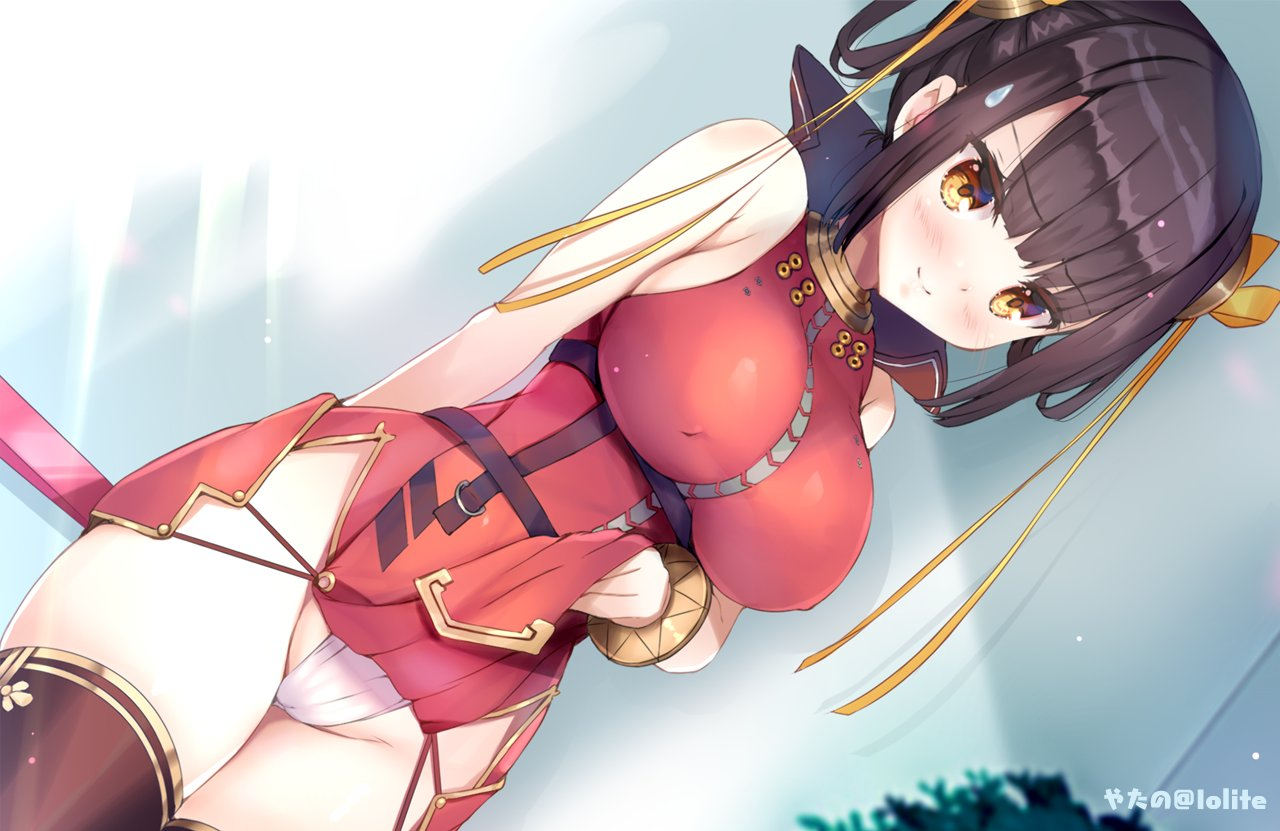

In [4]:
from datasets import load_dataset
from google.colab import userdata
from IPython.display import display, Markdown
import random

# ========= 설정 =========
IMG_REPO  = "pomupomu2/test_hbr_images"
META_REPO = "pomupomu2/test_hbr_meta"
hf_token = userdata.get("HF_KEY")

# ========= 로드 (첫 1회는 parquet 샤드 다운로드 때문에 시간이 걸릴 수 있음) =========
ds_img  = load_dataset(IMG_REPO,  split="train", token=hf_token)
ds_meta = load_dataset(META_REPO, split="train", token=hf_token)

# ========= 1) 이미지 쪽: md5 -> index 맵 (이미지 디코딩 없이 'md5 컬럼'만 사용) =========
img_md5s = [m.lower().strip() for m in ds_img["md5"]]
img_idx_by_md5 = {md5: i for i, md5 in enumerate(img_md5s) if md5}  # (이미 ds_img는 md5 dedup이라 보통 1:1)

# ========= 2) 메타 쪽: md5별 "최신 updated_at" row index만 보관 (컬럼 단위) =========
meta_md5s       = [m.lower().strip() for m in ds_meta["md5"]]
meta_updated_ats = ds_meta["updated_at"]  # ISO 문자열(예: 2025-...Z)이라 문자열 비교로 최신 판별 가능

best_meta_row_by_md5 = {}  # md5 -> (best_updated_at, row_index)
for j, md5 in enumerate(meta_md5s):
    if not md5:
        continue
    upd = meta_updated_ats[j] or ""
    prev = best_meta_row_by_md5.get(md5)
    if (prev is None) or (upd > prev[0]):  # ISO 문자열이므로 사전식 비교가 시간 비교와 일치
        best_meta_row_by_md5[md5] = (upd, j)

meta_md5_set = set(best_meta_row_by_md5.keys())

# ========= 3) 조인 가능한 md5 교집합에서 하나 랜덤 샘플 =========
joinable_md5s = list(set(img_idx_by_md5.keys()) & meta_md5_set)
if not joinable_md5s:
    raise RuntimeError("조인 가능한 md5가 없습니다. (이미지/메타가 서로 매칭되지 않음)")

md5 = random.choice(joinable_md5s)

img_i = img_idx_by_md5[md5]
meta_j = best_meta_row_by_md5[md5][1]

# 이 시점에 딱 1개씩만 row를 가져오므로, 이미지 디코딩도 1장만 발생
img_row  = ds_img[img_i]
meta_row = ds_meta[meta_j]

# ========= 출력 유틸 =========
def fmt(arr, n=80):
    arr = arr or []
    s = " ".join(arr[:n])
    return s + (" ..." if len(arr) > n else "")

# ========= 표시 =========
display(Markdown(f"## md5 `{md5}`  post_id `{meta_row.get('post_id')}`  updated_at `{meta_row.get('updated_at')}`"))
display(Markdown(f"- artist: `{fmt(meta_row.get('tag_artist'))}`"))
display(Markdown(f"- copyright: `{fmt(meta_row.get('tag_copyright'))}`"))
display(Markdown(f"- character: `{fmt(meta_row.get('tag_character'))}`"))
display(Markdown(f"- meta: `{fmt(meta_row.get('tag_meta'))}`"))
display(Markdown(f"- general(head): `{fmt(meta_row.get('tag_general'), 40)}`"))

obj = img_row["image"]
display(obj["image"] if isinstance(obj, dict) and "image" in obj else obj)


In [4]:
from datasets import load_dataset
from google.colab import userdata

hf_token = userdata.get("HF_KEY")
META_REPO = "pomupomu2/test_hbr_meta"

ds_meta = load_dataset(META_REPO, split="train", token=hf_token)

post_ids = [r["post_id"] for r in ds_meta]
print("meta rows:", len(ds_meta))
print("unique post_id:", len(set(post_ids)))


README.md:   0%|          | 0.00/957 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/1.50M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5000 [00:00<?, ? examples/s]

meta rows: 5000
unique post_id: 5000


In [5]:
IMG_REPO = "pomupomu2/test_hbr_images"
ds_img = load_dataset(IMG_REPO, split="train", token=hf_token)

md5s = ds_img["md5"]                      # ✅ 컬럼만 가져오기 (빠름)
print("images rows:", len(ds_img))
print("unique md5:", len(set(m.lower().strip() for m in md5s if m)))


README.md:   0%|          | 0.00/524 [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

data/train-00000-of-00023.parquet:   0%|          | 0.00/779M [00:00<?, ?B/s]

data/train-00001-of-00023.parquet:   0%|          | 0.00/950M [00:00<?, ?B/s]

data/train-00002-of-00023.parquet:   0%|          | 0.00/863M [00:00<?, ?B/s]

data/train-00003-of-00023.parquet:   0%|          | 0.00/877M [00:00<?, ?B/s]

data/train-00004-of-00023.parquet:   0%|          | 0.00/756M [00:00<?, ?B/s]

data/train-00005-of-00023.parquet:   0%|          | 0.00/582M [00:00<?, ?B/s]

data/train-00006-of-00023.parquet:   0%|          | 0.00/663M [00:00<?, ?B/s]

data/train-00007-of-00023.parquet:   0%|          | 0.00/515M [00:00<?, ?B/s]

data/train-00008-of-00023.parquet:   0%|          | 0.00/334M [00:00<?, ?B/s]

data/train-00009-of-00023.parquet:   0%|          | 0.00/580M [00:00<?, ?B/s]

data/train-00010-of-00023.parquet:   0%|          | 0.00/365M [00:00<?, ?B/s]

data/train-00011-of-00023.parquet:   0%|          | 0.00/275M [00:00<?, ?B/s]

data/train-00012-of-00023.parquet:   0%|          | 0.00/227M [00:00<?, ?B/s]

data/train-00013-of-00023.parquet:   0%|          | 0.00/421M [00:00<?, ?B/s]

data/train-00014-of-00023.parquet:   0%|          | 0.00/388M [00:00<?, ?B/s]

data/train-00015-of-00023.parquet:   0%|          | 0.00/378M [00:00<?, ?B/s]

data/train-00016-of-00023.parquet:   0%|          | 0.00/372M [00:00<?, ?B/s]

data/train-00017-of-00023.parquet:   0%|          | 0.00/188M [00:00<?, ?B/s]

data/train-00018-of-00023.parquet:   0%|          | 0.00/417M [00:00<?, ?B/s]

data/train-00019-of-00023.parquet:   0%|          | 0.00/300M [00:00<?, ?B/s]

data/train-00020-of-00023.parquet:   0%|          | 0.00/282M [00:00<?, ?B/s]

data/train-00021-of-00023.parquet:   0%|          | 0.00/477M [00:00<?, ?B/s]

data/train-00022-of-00023.parquet:   0%|          | 0.00/313M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/21 [00:00<?, ?it/s]

images rows: 5000
unique md5: 5000


In [6]:
HF_IMAGES = "pomupomu2/test_hbr_images"
HF_META   = "pomupomu2/test_hbr_meta"

OUT_DIR = "/content/tagutl_nanami"   # 코랩 로컬 폴더

MAX_ROWS = None  # 디버그용. None이면 전체

# include: OR-of-AND (general+meta 합친 태그셋에 적용)
INCLUDE_GROUPS = [
    ["1girl", "solo"],
    ["2girls"],
]

# exclude: general+meta 합친 태그셋에 적용
EXCLUDE_TAGS = {
    "4girls","5girls","6+girls",
    "4koma","comic",
    "kayamori_ruka",
    "izumi_yuki_(heaven_burns_red)",
    "translation_request"
}

RATING_WHITELIST = {"g", "s"}  # g,s만 (원하면 {"g","s","q"})

# 캡션 구성
CAPTION_INCLUDE = dict(
    artist=True,
    copyright=True,
    character=True,
    general=True,
    meta=True,
)

# 동작 옵션
OVERWRITE_IMAGES = False       # 이미 이미지 있으면 덮어쓸지
OVERWRITE_CAPTIONS = True      # 메타 업데이트 반영하려면 True 추천
WRITE_INDEX_JSONL = True


In [7]:
from google.colab import userdata
hf_token = userdata.get("HF_KEY")
if not hf_token:
    raise RuntimeError("HF_KEY 토큰을 찾지 못했습니다.")

import os, json, shutil
from datasets import load_dataset
from datasets import Image as HFImage
from tqdm.auto import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

# =========================
# 설정
# =========================
HF_IMAGES = "pomupomu2/test_hbr_images"
HF_META   = "pomupomu2/test_hbr_meta"

OUT_DIR = "/content/tagutl_nanami"
MAX_ROWS = None

INCLUDE_GROUPS = [
    ["1girl", "solo"],
    ["2girls"],
]

EXCLUDE_TAGS = {
    "4girls","5girls","6+girls",
    "4koma","comic",
    "kayamori_ruka",
    "izumi_yuki_(heaven_burns_red)",
    "translation_request"
}

RATING_WHITELIST = {"g", "s"}

CAPTION_INCLUDE = dict(
    artist=True,
    copyright=True,
    character=True,
    general=True,
    meta=True,
)

OVERWRITE_IMAGES = False
OVERWRITE_CAPTIONS = True
WRITE_INDEX_JSONL = True

# ✅ 저장(복사) 단계 워커 수만 별도로 조절
# copy는 I/O 병목이라 4~8 중에서 가장 빠른 값 쓰면 됨
SAVE_WORKERS = 6

# -------------------------
# 유틸
# -------------------------
def ensure_dir(p):
    os.makedirs(p, exist_ok=True)

def norm(tags):
    return [t.strip().lower() for t in (tags or []) if t and t.strip()]

def passes_include(tagset, groups):
    if not groups:
        return True
    for g in groups:
        if all(t.lower() in tagset for t in g):
            return True
    return False

def make_caption(parts):
    out = []
    for arr in parts:
        if arr:
            out.extend(arr)
    return " ".join(out).strip()

def write_bytes_atomic(data: bytes, out_path: str):
    root, ext = os.path.splitext(out_path)
    tmp = root + ".tmp" + ext
    with open(tmp, "wb") as f:
        f.write(data)
    os.replace(tmp, out_path)

def copy_atomic(src_path: str, out_path: str):
    root, ext = os.path.splitext(out_path)
    tmp = root + ".tmp" + ext
    shutil.copy2(src_path, tmp)
    os.replace(tmp, out_path)

def save_image_raw_atomic(image_obj, out_path: str):
    """
    image_obj: HFImage(decode=False)일 때 보통 dict 형태:
      {"path": "...", "bytes": None} 또는 {"path": None, "bytes": b"..."}
    """
    if isinstance(image_obj, dict):
        b = image_obj.get("bytes", None)
        p = image_obj.get("path", None)
        if b is not None:
            write_bytes_atomic(b, out_path)
            return
        if p:
            copy_atomic(p, out_path)
            return
    raise TypeError(f"Unexpected image object for raw save: {type(image_obj)} {image_obj}")

# -------------------------
# 출력 폴더 준비
# -------------------------
images_dir = os.path.join(OUT_DIR, "images")
caps_dir   = os.path.join(OUT_DIR, "captions")
ensure_dir(images_dir)
ensure_dir(caps_dir)

index_path = os.path.join(OUT_DIR, "index.jsonl")
index_f = open(index_path, "w", encoding="utf-8") if WRITE_INDEX_JSONL else None

exclude_norm = set(t.lower() for t in EXCLUDE_TAGS)
rating_whitelist = set([r.lower().strip() for r in (RATING_WHITELIST or set())])

print("Loading HF datasets...")
ds_img  = load_dataset(HF_IMAGES, split="train", token=hf_token)
ds_img  = ds_img.cast_column("image", HFImage(decode=False))  # ✅ PIL 디코딩 OFF
ds_meta = load_dataset(HF_META,  split="train", token=hf_token)

# =========================================================
# 1) meta: md5 -> 최신 row index 만들기
# =========================================================
print("Building meta index (latest by md5)...")
meta_md5s        = [m.lower().strip() for m in ds_meta["md5"]]
meta_updated_ats = ds_meta["updated_at"]

best_meta_row_by_md5 = {}  # md5 -> (best_updated_at, row_index)
for j, md5 in enumerate(meta_md5s):
    if not md5:
        continue
    upd = meta_updated_ats[j] or ""
    prev = best_meta_row_by_md5.get(md5)
    if (prev is None) or (upd > prev[0]):  # ISO 문자열 비교
        best_meta_row_by_md5[md5] = (upd, j)

meta_md5_set = set(best_meta_row_by_md5.keys())

meta_cols = {
    "post_id": ds_meta["post_id"],
    "updated_at": ds_meta["updated_at"],
    "created_at": ds_meta["created_at"],
    "rating": ds_meta["rating"],
    "tag_artist": ds_meta["tag_artist"],
    "tag_copyright": ds_meta["tag_copyright"],
    "tag_character": ds_meta["tag_character"],
    "tag_general": ds_meta["tag_general"],
    "tag_meta": ds_meta["tag_meta"],
}

# =========================================================
# 2) img: md5/ext 컬럼만으로 후보 인덱스 구성 (디코딩 X)
# =========================================================
print("Pre-filtering by md5 (no image decoding)...")
img_md5s = [m.lower().strip() for m in ds_img["md5"]]
img_exts = ds_img["file_ext"]

candidate_indices = []
skipped_no_meta = 0
for i, md5 in enumerate(img_md5s):
    if not md5:
        continue
    if md5 not in meta_md5_set:
        skipped_no_meta += 1
        continue
    candidate_indices.append(i)

print(f"Candidates with meta: {len(candidate_indices)} (skipped_no_meta={skipped_no_meta})")

# =========================================================
# 3) 메인: 필터링 + 캡션/인덱스 작성 + 저장 작업 목록 생성
# =========================================================
kept = 0
skipped_rating = 0
skipped_filter = 0
skipped_existing_img = 0
written_caps = 0

save_tasks = []  # (row_index, out_path)

for i in tqdm(candidate_indices, desc="Filtering+captions"):
    md5 = img_md5s[i]
    meta_j = best_meta_row_by_md5[md5][1]

    rating = (meta_cols["rating"][meta_j] or "").lower().strip()
    if rating_whitelist and rating not in rating_whitelist:
        skipped_rating += 1
        continue

    tag_artist    = norm(meta_cols["tag_artist"][meta_j])
    tag_copyright = norm(meta_cols["tag_copyright"][meta_j])
    tag_character = norm(meta_cols["tag_character"][meta_j])
    tag_general   = norm(meta_cols["tag_general"][meta_j])
    tag_meta      = norm(meta_cols["tag_meta"][meta_j])

    tagset = set(tag_general) | set(tag_meta)

    if not passes_include(tagset, INCLUDE_GROUPS):
        skipped_filter += 1
        continue
    if exclude_norm and (tagset & exclude_norm):
        skipped_filter += 1
        continue

    parts = []
    if CAPTION_INCLUDE.get("artist"): parts.append(tag_artist)
    if CAPTION_INCLUDE.get("copyright"): parts.append(tag_copyright)
    if CAPTION_INCLUDE.get("character"): parts.append(tag_character)
    if CAPTION_INCLUDE.get("general"): parts.append(tag_general)
    if CAPTION_INCLUDE.get("meta"): parts.append(tag_meta)
    caption = make_caption(parts)
    if not caption:
        skipped_filter += 1
        continue

    file_ext = (img_exts[i] or "jpg").lower().strip()
    if file_ext == "jpeg":
        file_ext = "jpg"

    img_path = os.path.join(images_dir, f"{md5}.{file_ext}")
    cap_path = os.path.join(caps_dir, f"{md5}.txt")

    # 캡션 저장(메인에서)
    if (not os.path.exists(cap_path)) or OVERWRITE_CAPTIONS:
        with open(cap_path, "w", encoding="utf-8") as f:
            f.write(caption + "\n")
        written_caps += 1

    # index.jsonl(메인에서)
    if index_f is not None:
        rec = dict(
            md5=md5,
            post_id=int(meta_cols["post_id"][meta_j] or 0),
            updated_at=meta_cols["updated_at"][meta_j] or "",
            created_at=meta_cols["created_at"][meta_j] or "",
            rating=rating,
            file_ext=file_ext,
            image_path=os.path.relpath(img_path, OUT_DIR),
            caption_path=os.path.relpath(cap_path, OUT_DIR),
            tag_artist=tag_artist,
            tag_copyright=tag_copyright,
            tag_character=tag_character,
            tag_general=tag_general,
            tag_meta=tag_meta,
        )
        index_f.write(json.dumps(rec, ensure_ascii=False) + "\n")

    # 이미지 저장은 병렬 워커로
    if os.path.exists(img_path) and not OVERWRITE_IMAGES:
        skipped_existing_img += 1
    else:
        save_tasks.append((i, img_path))

    kept += 1
    if MAX_ROWS is not None and kept >= MAX_ROWS:
        break

if index_f is not None:
    index_f.close()

print("== Filter/caption stage done ==")
print("kept:", kept)
print("save_tasks:", len(save_tasks))
print("written_caps:", written_caps)
print("skipped_no_meta:", skipped_no_meta)
print("skipped_rating:", skipped_rating)
print("skipped_filter:", skipped_filter)
print("skipped_existing_img:", skipped_existing_img)

# =========================================================
# 4) 멀티프로세스: 원본 복사 저장만 병렬 처리 (PIL 없음)
# =========================================================
_worker_ds_img = None
_worker_token = hf_token
_worker_repo  = HF_IMAGES

def _worker_init():
    global _worker_ds_img
    ds = load_dataset(_worker_repo, split="train", token=_worker_token)
    _worker_ds_img = ds.cast_column("image", HFImage(decode=False))  # ✅ 워커도 decode=False

def _worker_save_one(task):
    global _worker_ds_img
    i, out_path = task

    if os.path.exists(out_path) and not OVERWRITE_IMAGES:
        return ("skip_exists", i, out_path, None)

    try:
        row = _worker_ds_img[i]  # 디코딩 없음
        save_image_raw_atomic(row["image"], out_path)
        return ("ok", i, out_path, None)
    except Exception as e:
        return ("err", i, out_path, repr(e))

written_imgs = 0
skipped_imgs = 0
failed_imgs  = 0

if save_tasks:
    print(f"Saving images by raw copy... workers={SAVE_WORKERS}")
    with ProcessPoolExecutor(max_workers=SAVE_WORKERS, initializer=_worker_init) as ex:
        futures = [ex.submit(_worker_save_one, t) for t in save_tasks]
        for f in tqdm(as_completed(futures), total=len(futures), desc="Saving images"):
            status, i, out_path, err = f.result()
            if status == "ok":
                written_imgs += 1
            elif status == "skip_exists":
                skipped_imgs += 1
            else:
                failed_imgs += 1
                print("[SAVE FAIL]", i, out_path, err)

print("== Export done ==")
print("written_imgs:", written_imgs, "skipped_imgs:", skipped_imgs, "failed_imgs:", failed_imgs)
print("OUT_DIR:", OUT_DIR)
print("index.jsonl:", index_path if WRITE_INDEX_JSONL else "(disabled)")


Loading HF datasets...


Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/21 [00:00<?, ?it/s]

Building meta index (latest by md5)...
Pre-filtering by md5 (no image decoding)...
Candidates with meta: 5000 (skipped_no_meta=0)


Filtering+captions:   0%|          | 0/5000 [00:00<?, ?it/s]

== Filter/caption stage done ==
kept: 3496
save_tasks: 3496
written_caps: 3496
skipped_no_meta: 0
skipped_rating: 339
skipped_filter: 1165
skipped_existing_img: 0
Saving images by raw copy... workers=6


Saving images:   0%|          | 0/3496 [00:00<?, ?it/s]

== Export done ==
written_imgs: 3496 skipped_imgs: 0 failed_imgs: 0
OUT_DIR: /content/tagutl_nanami
index.jsonl: /content/tagutl_nanami/index.jsonl


### 8bb3c47e5de39e88b7a0e0ce10aa1453

- image: `/content/tagutl_nanami/images/8bb3c47e5de39e88b7a0e0ce10aa1453.jpg`

- caption: `wbon heaven_burns_red mikoto_fubuki murohushi_risa 2girls black_hair black_hairband breasts choker cleavage coat collarbone denim gas_mask green_hair hairband jacket leotard long_hair mask mole mole_under_mouth multicolored_hair multiple_gi...`

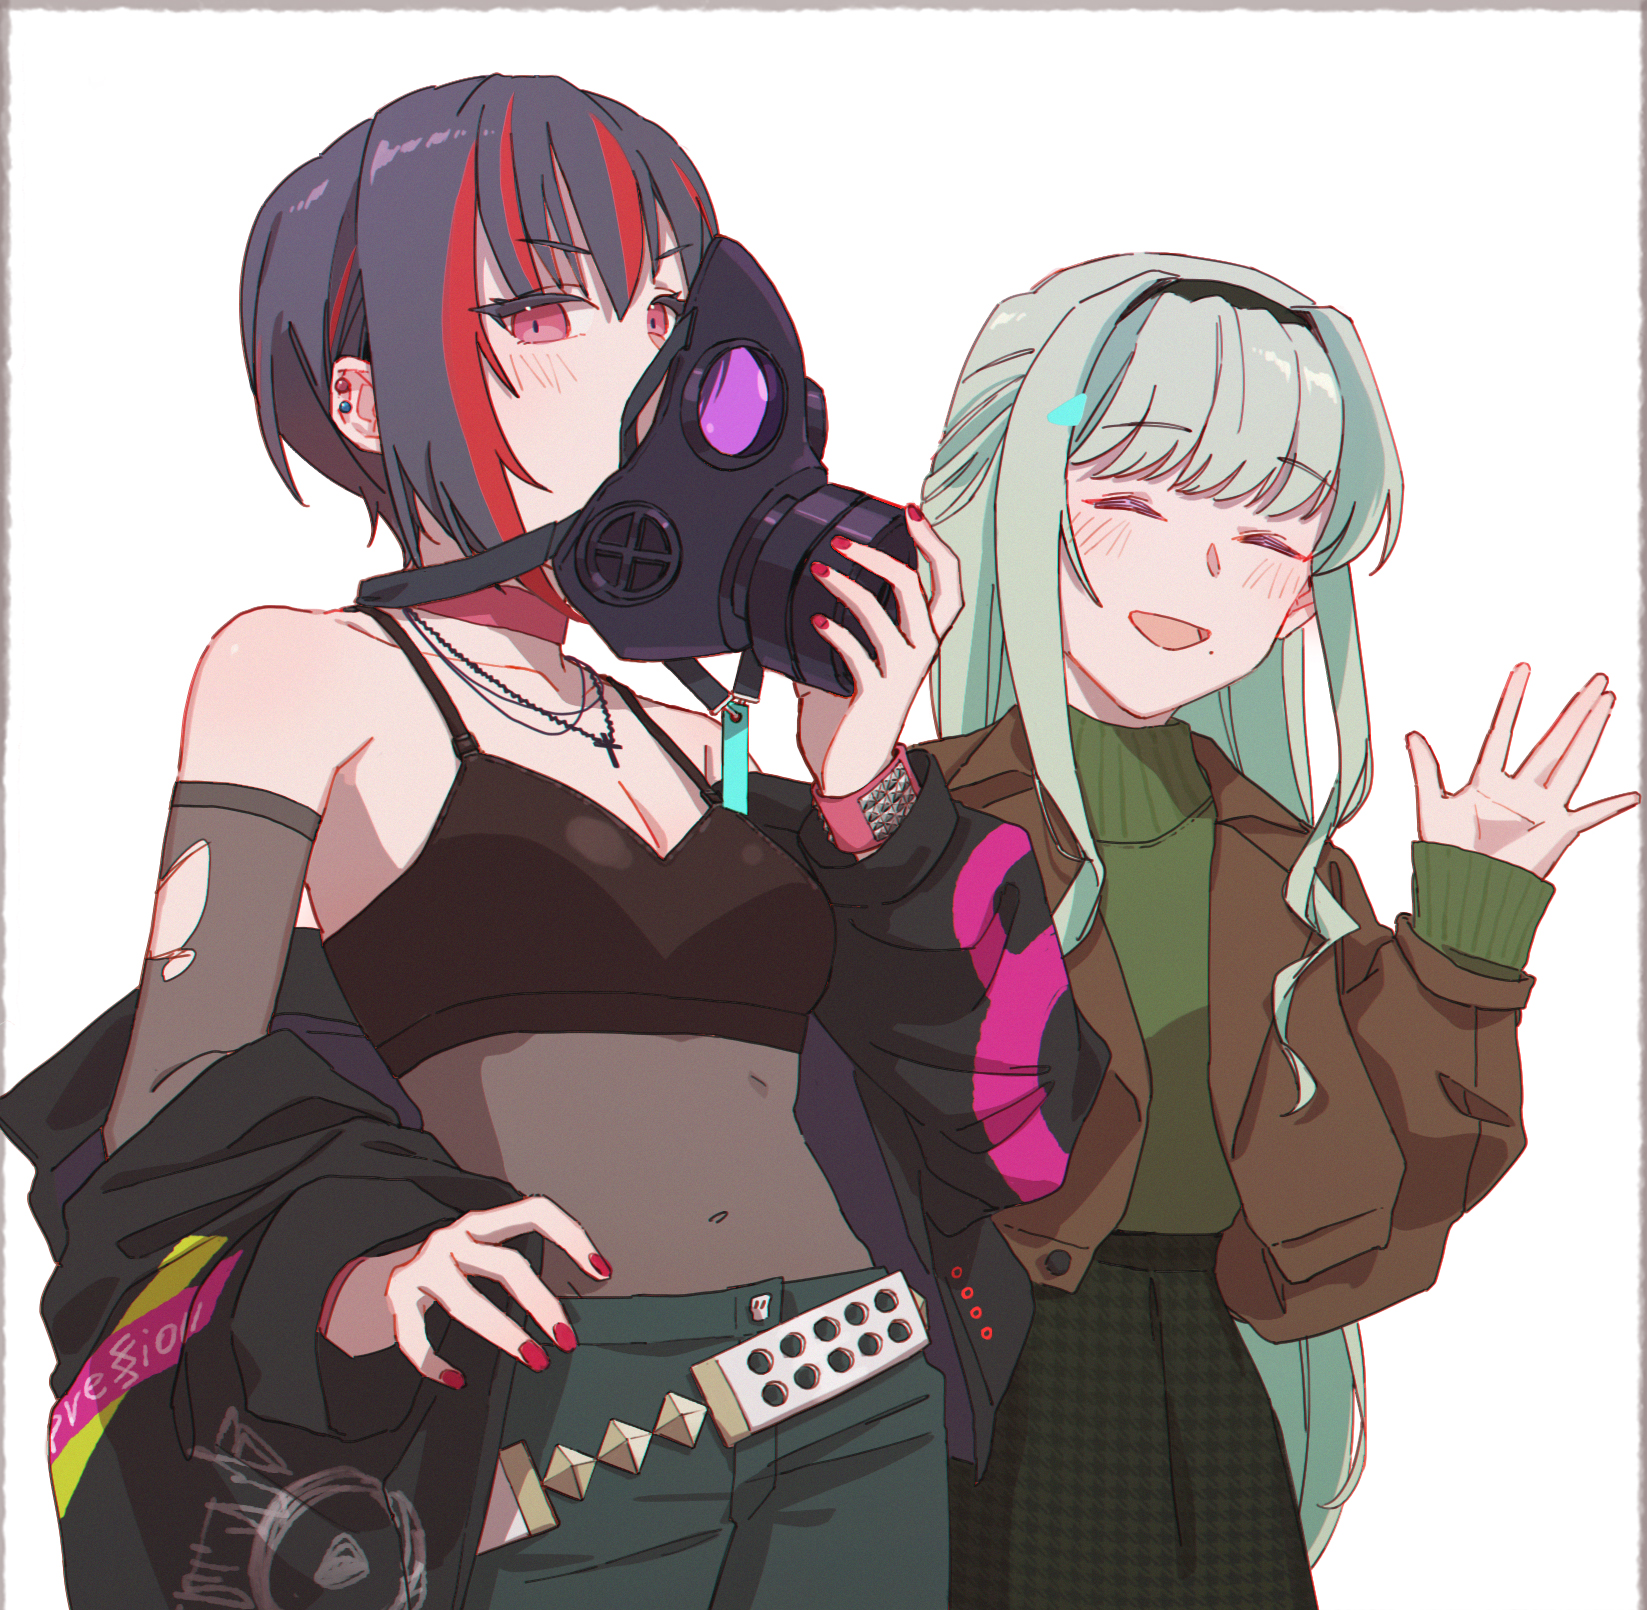

### c7282bef028ca91f794afaee1193be01

- image: `/content/tagutl_nanami/images/c7282bef028ca91f794afaee1193be01.jpg`

- caption: `kiri_giri41 heaven_burns_red charlotta_skopovskaya 1girl explosive fur_hat grenade grenade_pin grey_hair happy_birthday hat holding holding_grenade long_hair papakha solo stuffed_animal stuffed_toy yellow_eyes commentary`

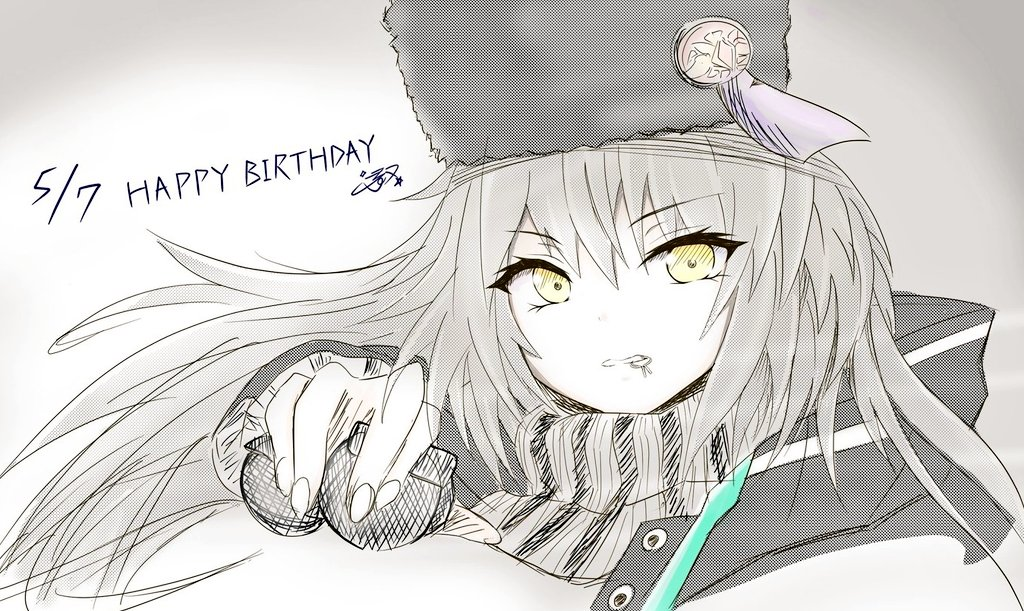

### 2071d1bad4d146bd4a0dec604f98ef08

- image: `/content/tagutl_nanami/images/2071d1bad4d146bd4a0dec604f98ef08.jpg`

- caption: `kaki. heaven_burns_red sugawara_chie 1girl black_bow black_gloves blunt_bangs blush bow bowtie claw_pose closed_mouth cowboy_shot frilled_hairband frilled_skirt frills gloves green_eyes hair_bow hairband leaning_forward lolita_fashion lolit...`

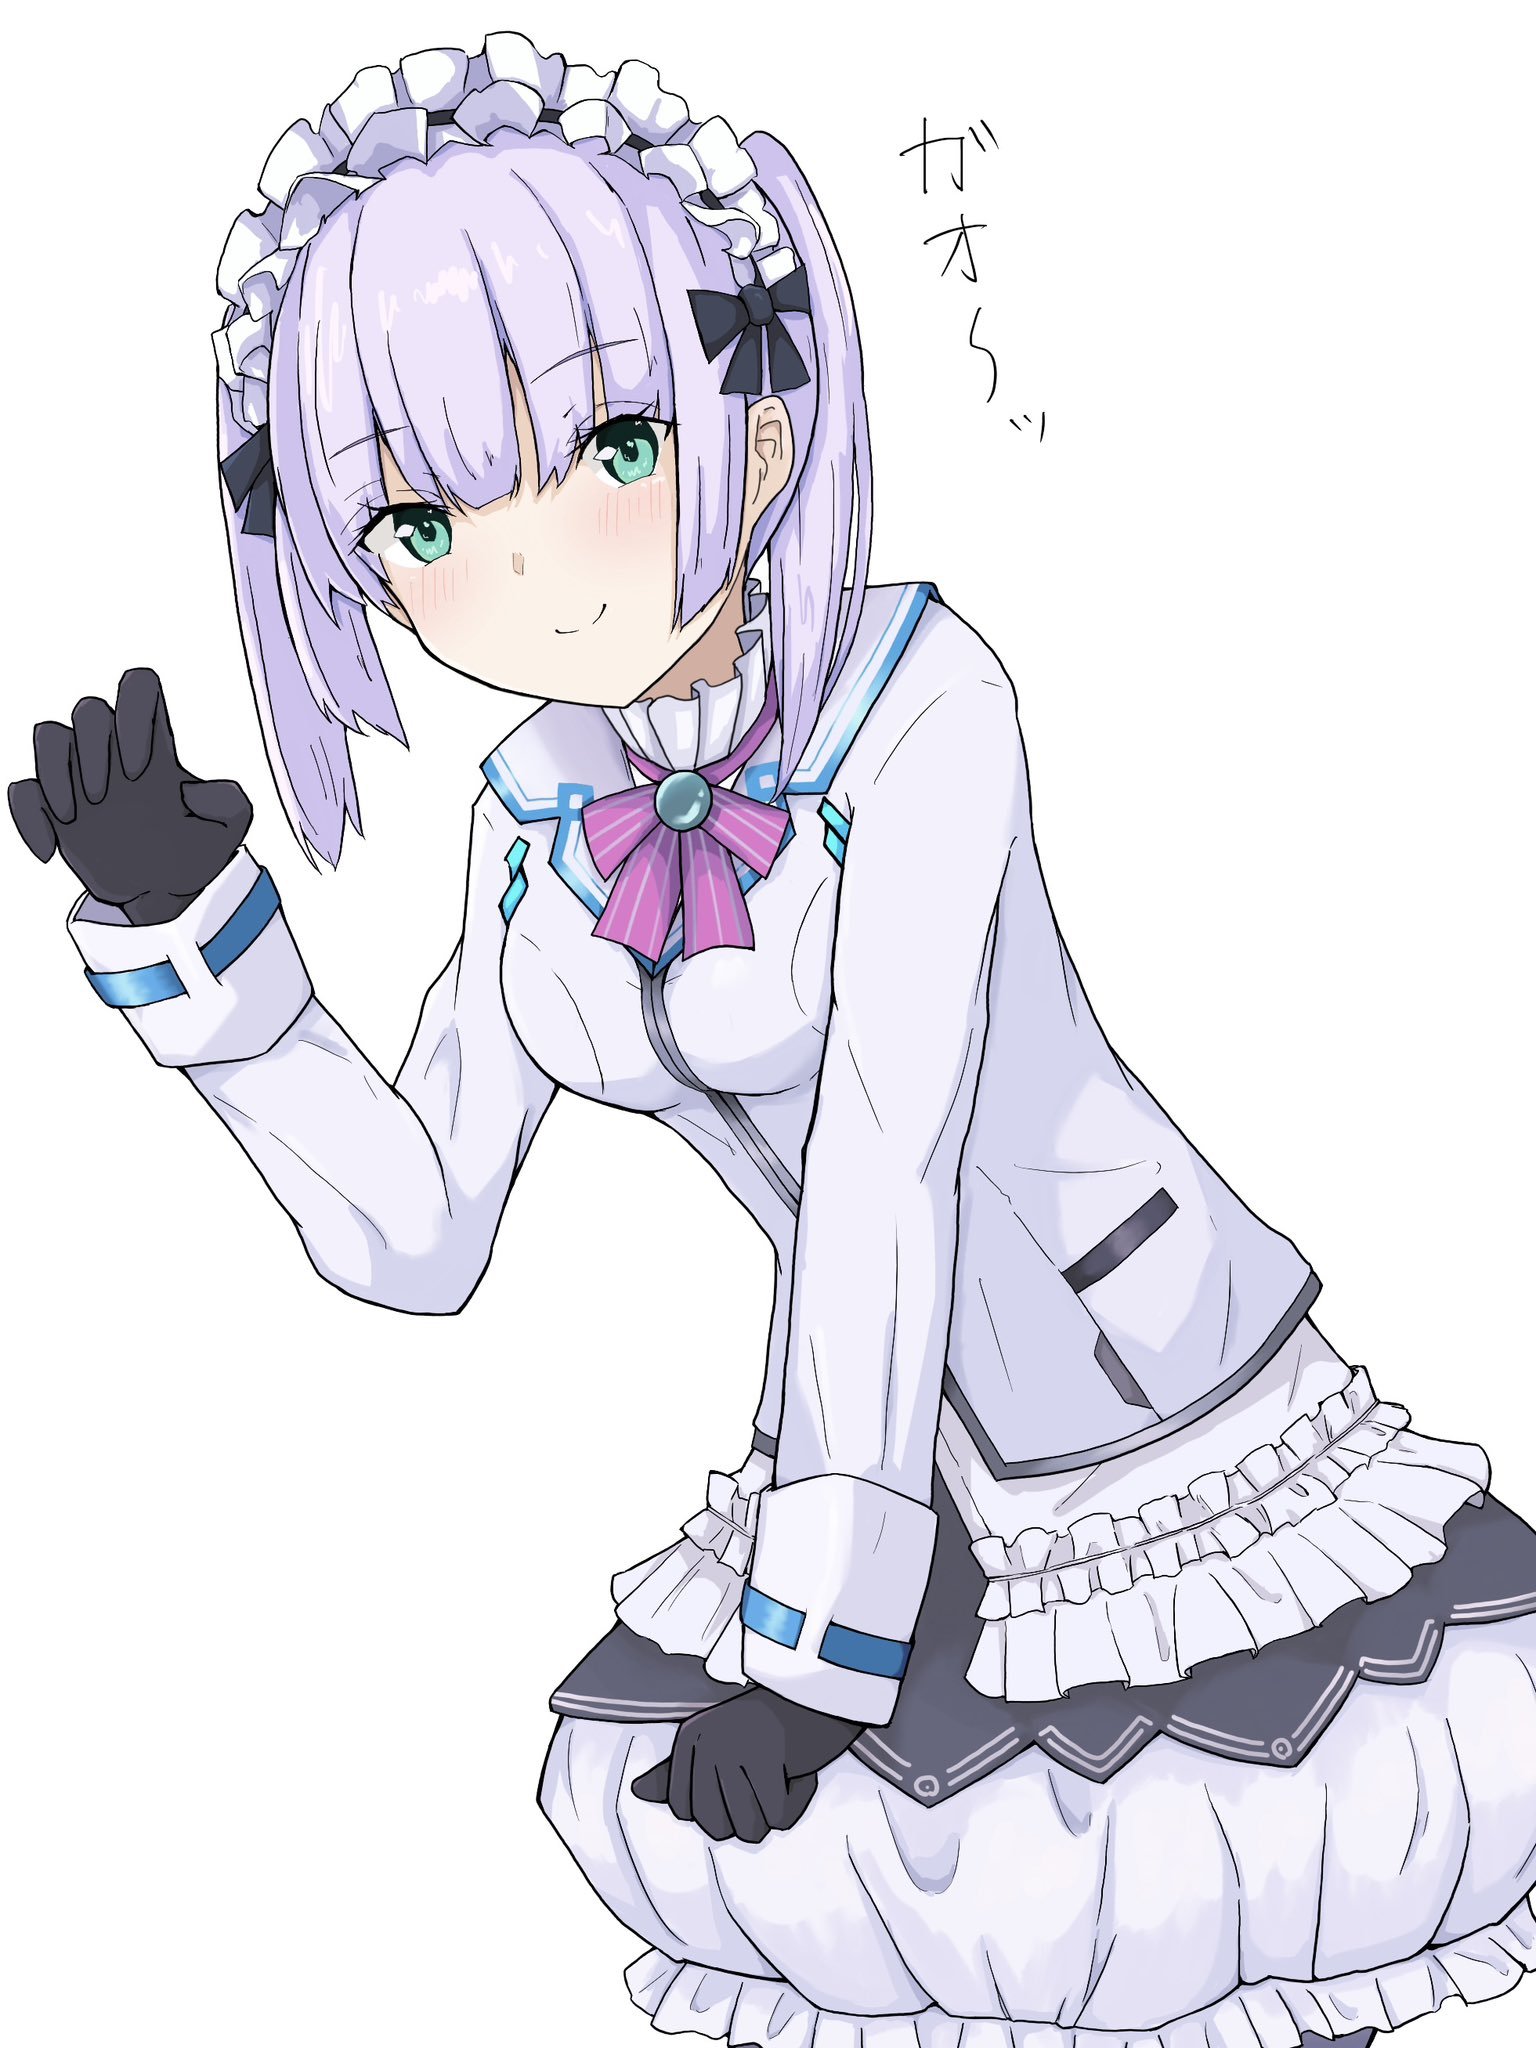

In [8]:
import glob, random, os
from IPython.display import display, Markdown, Image as IPyImage

imgs = glob.glob(os.path.join(OUT_DIR, "images", "*.*"))
samples = random.sample(imgs, k=min(3, len(imgs)))

for p in samples:
    md5 = os.path.splitext(os.path.basename(p))[0]
    cap = os.path.join(OUT_DIR, "captions", md5 + ".txt")
    cap_text = open(cap, encoding="utf-8").read().strip() if os.path.exists(cap) else "(missing)"
    display(Markdown(f"### {md5}"))
    display(Markdown(f"- image: `{p}`"))
    display(Markdown(f"- caption: `{cap_text[:240]}{'...' if len(cap_text)>240 else ''}`"))
    display(IPyImage(filename=p))


In [9]:
!pip -q install pillow

In [10]:
!unzip -o viewer_colab.zip -d /content/viewer
!ls /content/viewer

Archive:  viewer_colab.zip
  inflating: /content/viewer/app.js  
  inflating: /content/viewer/index.html  
  inflating: /content/viewer/server.py  
  inflating: /content/viewer/styles.css  
app.js	index.html  server.py  styles.css


In [11]:
import os, json

OUT_DIR = "/content/tagutl_nanami"
src = os.path.join(OUT_DIR, "index.jsonl")
dst = os.path.join(OUT_DIR, "dataset_index_fixed.jsonl")

n = 0
with open(src, "r", encoding="utf-8") as f_in, open(dst, "w", encoding="utf-8") as f_out:
    for line in f_in:
        line = line.strip()
        if not line:
            continue
        r = json.loads(line)

        out = {
            # viewer가 실제 파일을 찾을 때 쓰는 값
            "image_path": r["image_path"],

            # viewer가 태그 표시할 때 쓰는 값 (키 이름만 맞춰주면 됨)
            "artist": r.get("tag_artist", []),
            "copyright": r.get("tag_copyright", []),
            "character": r.get("tag_character", []),
            "general": r.get("tag_general", []),

            # 유지하고 싶으면 추가 필드로 남겨도 됨(기본 viewer는 무시)
            "meta": r.get("tag_meta", []),

            # 디버깅/추적용(있어도 viewer는 무시)
            "md5": r.get("md5"),
            "post_id": r.get("post_id"),
            "created_at": r.get("created_at"),
            "updated_at": r.get("updated_at"),
            "rating": r.get("rating"),
            "file_ext": r.get("file_ext"),
            "caption_path": r.get("caption_path"),
        }

        f_out.write(json.dumps(out, ensure_ascii=False) + "\n")
        n += 1

print("saved:", dst)
print("rows:", n)


saved: /content/tagutl_nanami/dataset_index_fixed.jsonl
rows: 3496


In [12]:
import os, subprocess, socket, time

PORT = 8188
ROOT = OUT_DIR
VIEWER_LOG = "/content/viewer.log"

# 기존 서버 있으면 종료
subprocess.run(["pkill", "-f", "/content/viewer/server.py"], check=False)

log_f = open(VIEWER_LOG, "w")

viewer_proc = subprocess.Popen(
    [
        "python", "/content/viewer/server.py",
        "--root", ROOT,
        "--port", str(PORT),

        # (선택) 썸네일/디스플레이 생성 부담 줄이기
        "--thumb-size", "256",
        "--thumb-quality", "75",
        "--display-size", "1200",
        "--display-quality", "82",
    ],
    stdout=log_f,
    stderr=subprocess.STDOUT,
)

def wait_port(port, timeout=30):
    t0 = time.time()
    while time.time() - t0 < timeout:
        time.sleep(0.3)
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as sock:
            if sock.connect_ex(("127.0.0.1", port)) == 0:
                return True
    return False

ok = wait_port(PORT)
print("✅ Viewer ready" if ok else "❌ Viewer did not open port")
print(f"local: http://127.0.0.1:{PORT}")
print(f"log:  {VIEWER_LOG}")


✅ Viewer ready
local: http://127.0.0.1:8188
log:  /content/viewer.log


In [16]:
%%bash
if ! command -v cloudflared >/dev/null 2>&1; then
  wget -q -O /tmp/cloudflared.deb https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
  dpkg -i /tmp/cloudflared.deb >/dev/null 2>&1 || apt-get -y -f install >/dev/null 2>&1
fi

cloudflared --version
which cloudflared

cloudflared version 2025.11.1 (built 2025-11-07-16:59 UTC)
/usr/local/bin/cloudflared


In [17]:
import subprocess, time, re

TUN_LOG = "/content/cloudflared.log"

# 기존 터널 있으면 종료
subprocess.run(["pkill", "-f", "cloudflared tunnel"], check=False)

tun_f = open(TUN_LOG, "w")

tun_proc = subprocess.Popen(
    ["cloudflared", "tunnel", "--protocol", "http2", "--url", "http://127.0.0.1:8188"],
    stdout=tun_f,
    stderr=subprocess.STDOUT,
)

time.sleep(3)
print("✅ Cloudflared started")
print("log:", TUN_LOG)

# 터널 URL 한 번 뽑아보기(로그에서 trycloudflare 주소 찾기)
try:
    with open(TUN_LOG, "r", encoding="utf-8", errors="ignore") as f:
        txt = f.read()
    m = re.search(r"https://[a-z0-9-]+\.trycloudflare\.com", txt)
    if m:
        print("✅ Tunnel URL:", m.group(0))
    else:
        print("⚠️ Tunnel URL not found yet. Check logs.")
except Exception as e:
    print("log read failed:", e)


✅ Cloudflared started
log: /content/cloudflared.log
⚠️ Tunnel URL not found yet. Check logs.


In [18]:
import time, re

TUN_LOG = "/content/cloudflared.log"

url = None
for _ in range(30):  # 최대 ~15초
    time.sleep(0.5)
    try:
        with open(TUN_LOG, "r", encoding="utf-8", errors="ignore") as f:
            txt = f.read()
        m = re.search(r"https://[a-z0-9-]+\.trycloudflare\.com", txt)
        if m:
            url = m.group(0)
            break
    except Exception:
        pass

if url:
    print("✅ Tunnel URL:", url)
else:
    print("❌ Still no URL. Showing last 80 log lines:")
    print("-" * 60)
    !tail -n 80 /content/cloudflared.log


✅ Tunnel URL: https://schools-reservations-chemical-satisfactory.trycloudflare.com


In [22]:
!tail -n 60 /content/viewer.log
!tail -n 120 /content/cloudflared.log

2026-01-17T14:00:18Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2026-01-17T14:00:18Z INF Requesting new quick Tunnel on trycloudflare.com...
2026-01-17T14:00:22Z INF +--------------------------------------------------------------------------------------------+
2026-01-17T14:00:22Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
2026-01-17T14:00:22Z INF |  https://clan-internet-anderson-maintaining.trycloudfl

In [23]:
try:
    viewer_proc.terminate()
    viewer_proc.wait(timeout=3)
except Exception:
    pass

# Danbooru → Hugging Face Dataset 운영 메모 (재개/중복/메타갱신 포함)

이 저장소(들)는 Danbooru에서 이미지와 메타데이터를 수집해 Hugging Face Datasets(Hub)에 올리고,
런타임 중단/재실행에도 **중복 다운로드 없이 이어받고**, 태그 변경 같은 **메타 갱신도 반영**하기 위한 운영 기록이다.

---

## 0) 핵심 요약 (한 줄씩)

- Danbooru의 기본 단위는 **post**(id)이고, 파일 단위 중복 제거는 **md5**가 가장 안정적이다.
- Danbooru는 태그/메타가 바뀌면 `updated_at`이 바뀌고 `order:updated` 정렬에서 글이 위로 튀어오른다.
- HF Datasets는 같은 split 내에서 **스키마(features)가 같아야** 하므로, 서로 다른 테이블(images/meta)은 **repo를 분리**하는 게 운영이 쉽다.
- 재개(resume)는 gallery-dl의 `--download-archive`(sqlite3)로 해결한다.
- 메타 갱신은 `order:updated` 상위 N페이지를 주기적으로 재스캔해서 snapshot을 누적하고, 학습 시 최신만 선택한다.

---

## 1) Danbooru 데이터 모델 정리

### 1.1 Post와 ID
- Danbooru에서 검색 결과의 한 항목은 **post**다.
- `post_id`(= `id`)는 한 번 생성되면 **변하지 않는 식별자**다.
- 다만 “검색 목록에서의 위치”는 정렬 기준에 따라 계속 바뀐다.
  - `order:id` : id 기준 정렬(안정적)
  - `order:updated` : 태그/메타가 업데이트되면 위로 이동(불안정)
  - `order:score` 등 : 점수 변화에 따라 이동

### 1.2 md5 (파일 단위 식별자)
- Danbooru JSON 메타에 `md5`가 존재하며, 이는 파일(바이너리) 단위의 사실상 고유키로 사용 가능하다.
- post가 그대로여도 파일이 교체되면 md5가 바뀔 수 있다.
- 따라서:
  - **파일 중복 제거/저장**은 md5 중심
  - **포스트/태그 변화 추적**은 post_id + updated_at 중심

### 1.3 태그 업데이트는 자주 일어난다
- 유저들이 태그/메타를 계속 수정한다.
- `updated_at`이 갱신되면 `order:updated`에서 오래된 글이 최신 목록으로 올라갈 수 있다.
- 승인(pending approval) 상태 변화도 검색 결과 포함 여부에 영향을 줄 수 있다.

---

## 2) Hugging Face Datasets 구조/제약

### 2.1 HF Dataset repo 내부 구조
- `push_to_hub()`를 하면 대체로 `data/train-00000-of-00001.parquet` 같은 parquet shard가 생성된다.
- HF는 split(`train`, `test`, `validation` 등)별로 **하나의 테이블 스키마(features)**를 가진다고 보면 된다.

### 2.2 중요한 제약: 같은 split에 서로 다른 스키마를 섞을 수 없다
- `DatasetDict`는 “서로 다른 스키마의 테이블 묶음”이 아니라 “split 묶음”이다.
- images 테이블과 meta 테이블은 컬럼이 다르므로, 같은 repo에 동시에 올리려 하면 스키마 불일치 오류가 날 수 있다.

**권장 구조**
- `*_images` repo: 이미지 테이블 1개 (train split)
- `*_meta` repo: 메타 테이블 1개 (train split)

---

## 3) 운영 설계 (이번 파이프라인 기준)

### 3.1 Repo 분리 설계

#### A) images repo (파일 단위)
- 기본키: `md5`
- 컬럼 예시:
  - `md5` (string)
  - `image` (datasets.Image)
  - `file_ext` (string)
  - `file_size` (int64)
  - `first_seen_post_id` (int64)
  - `first_seen_at` (string, ISO)
  - `source_file_url` (string)

#### B) meta repo (post 스냅샷)
- 스냅샷 키(논리적): `(post_id, updated_at)`
- 컬럼 예시:
  - `post_id` (int64)
  - `updated_at` (string)
  - `created_at` (string)
  - `md5` (string)
  - `rating`, `score`, `fav_count`, `parent_id`, `source`, `is_deleted`
  - `tag_artist`, `tag_copyright`, `tag_character`, `tag_general` (list[string])
  - `post_url`, `file_url`, `large_file_url`, `preview_file_url`

### 3.2 재개(resume) 설계: gallery-dl archive + HF state
- 로컬:
  - `archive.sqlite3` : gallery-dl `--download-archive`로 생성
- HF(images repo)에 저장:
  - `state/archive.sqlite3`
  - `state/state.json` (예: `{ "last_run_at": "..." }`)

재실행 시:
1) HF에서 `state/archive.sqlite3`를 내려받아 로컬 archive로 사용
2) gallery-dl이 archive를 참고해서 이미 받은 건 스킵
3) 끝나면 최신 archive/state를 HF로 다시 업로드

### 3.3 메타 갱신 전략: `order:updated` 재스캔
Danbooru에서 태그/메타 업데이트가 발생하면 `order:updated` 상단으로 튀어오르므로:

- 기본 수집: `tags=<캐릭터>`
- 업데이트 재스캔: `tags=<캐릭터> order:updated` 상위 N페이지

이때 meta는 `(post_id, updated_at)` 기준으로 누적 저장하고,
학습 단계에서 `post_id`별로 최신 `updated_at`만 택하면 된다.

---

## 4) 이번에 실제로 겪은 실패와 원인(재발 방지용)

### 4.1 Danbooru API 422(TagLimitError)
- API 방식으로 조합 검색을 시도하면 태그 제한 등으로 422가 날 수 있다.
- 초반에 잘 되던 방식(웹 URL + gallery-dl)이 안정적이므로, 기본 수집은 gallery-dl 유지가 안전하다.

### 4.2 HF에서 images/meta를 한 repo에 올리려다 스키마 충돌
- DatasetDict는 split 묶음이므로 서로 다른 테이블 스키마(images/meta)를 함께 넣으면 오류가 날 수 있다.
- 해결: images repo와 meta repo를 분리.

### 4.3 `_load_split()`이 실패해서 기존 md5를 못 읽고 전부 “신규”로 처리됨
- 증상:
  - `images_existing is None? True`
  - `md5_existing size: 0`
  - 매 실행마다 “신규 N장”이 전체처럼 잡힘
- 원인:
  - `load_dataset()` 호출에 불필요한 옵션(data_files/use_auth_token/download_mode 등)을 섞어서
    환경/버전 차로 실패 가능성이 커짐
- 해결:
  - **검증된 최소 호출만 사용**: `load_dataset(repo_id, split="train", token=hf_token)`

### 4.4 hub API 호출 방식(TypeError)
- `HfApi.upload_file()`는 버전별로 keyword-only 인자 요구 등 차이가 있어,
  positional 호출로 쉽게 깨진다.
- 해결:
  - dataset 업로드는 `push_to_hub()` 중심으로 통일
  - 상태 파일만 `upload_file(keyword-only)`로 업로드

---

## 5) 다음 실행 체크리스트 (이 순서대로 하면 안전)

1) **state 존재 확인**
   - HF(images repo)에서 `state/archive.sqlite3`, `state/state.json` 파일이 있는지 확인

2) **기존 dataset 로드 확인**
   - `load_dataset(images_repo, split="train", token=...)`가 성공하는지 확인
   - 실패하면 md5_existing이 비게 되므로, 그 run에서는 “중복 제외”가 깨진다(중단 권장)

3) **gallery-dl 실행**
   - 기본 수집 + `order:updated` 상위 N페이지 재스캔

4) **dedup 규칙**
   - images: md5 기준
   - meta: `(post_id, updated_at)` 기준

5) **업로드**
   - images repo(train), meta repo(train)
   - state/archive.sqlite3 + state/state.json 업로드

---

## 6) 학습에서 쓰는 방법(권장)

- meta repo에서 `post_id`별 최신 `updated_at`만 선택
- 그 최신 meta의 `md5`로 images repo와 조인
- caption은 `tag_*`를 원하는 규칙으로 조합해서 생성

> 저장 단계에서는 “최대한 원본에 가까운 누적/기록”을 유지하고,
> 학습 단계에서 필터링/최신선택/캡션정제 등을 수행하는 편이 운영이 안정적이다.

---
